Updated on 2025/03/17

* plot the first column with the original roughness data

Updated on 2025/03/05

* Now stress at grid points on the surface of the **volume** has been extracted into the CSV files.
* It is still necessary to fill the data into the structured grid points.


The COAT membrane was meshed freely into triangular elements.

The current script will only keep the structured grids which will be used to form output for CNN model.


# Import the libraries

Import the libraries to generate random surface

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import sys
import math
import pandas as pd
import openpyxl

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

Setting the folder where the extracted csv files were saved

In [2]:
print(f"Indicate the directory where csv files generated by python script 'extract_e11_from_rough_coat.py' were saved")
structured_mesh_csv_folder = 'C:\\Abaqus_Works\\roughness_simulation\\output_free_mesh'
structured_grid_xls_folder = 'C:\\Abaqus_Works\\roughness_simulation\\output_structured_grid'
input_rough_surf_csv_folder = 'C:\\Abaqus_Works\\roughness_simulation\\input_rough_surfaces'

Indicate the directory where csv files generated by python script 'extract_e11_from_rough_coat.py' were saved


# Functions to read Excel and plot figures

Extract stress from the sheets of two excels

In [3]:
def extract_stress(file_folder, file_name, sum_field):
    file_path = os.path.join(file_folder, file_name)
    if os.path.exists(file_path):
        print(f"✅ File exists: {file_path}")
        # Define the sheet names
        steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
        ss_comp = ['11', '22', '33', '12', '13', '23']
        sheet_names = [f"{steps_name[i // 6]}-S{ss_comp[i % 6]}" for i in range(sum_field)]

        # Read the data from each sheet into a list of DataFrames
        data_frames = [pd.read_excel(file_path, sheet_name=sheet_name, header=None) for sheet_name in sheet_names]

        # Convert the list of DataFrames to a three-dimensional NumPy array
        norm_stress_struct_grids = np.stack([df.to_numpy() for df in data_frames], axis=-1)

        return norm_stress_struct_grids
    else:
        print(f"❌ File NOT exist: {file_path}")
        sys.exit(1)
        return None

In [4]:
def calculate_tick_increment(vmin, vmax, num_ticks=10):
    """
    Dynamically calculate the increment for colorbar ticks.
    Parameters:
    - vmin: Minimum value of the range.
    - vmax: Maximum value of the range.
    - num_ticks: Desired number of ticks (default: 5).
    Returns:
    - increment: The calculated increment for the ticks.
    """
    range_values = vmax - vmin
    raw_increment = range_values / (num_ticks - 1)  # Divide range into (num_ticks - 1) intervals

    if raw_increment == 0:
        raise ValueError("The increment value must not be zero.")

    # Get the absolute value to handle negative numbers
    abs_inc = abs(raw_increment)
    
    # Calculate the index (power of 10)
    index = math.floor(math.log10(abs_inc))

    # Scale the value to make the first digit an integer
    scaled_value = abs_inc / (10 ** index)
    
    # Extract the first digit
    first_digit = int(math.ceil(scaled_value))

    inc_reg = first_digit * 10**index
    
    low_lim_reg = np.ceil(vmin/inc_reg)*inc_reg
    upp_lim_reg = (np.floor(vmax/inc_reg)+1)*inc_reg

    bar_ticks = np.arange(low_lim_reg, upp_lim_reg, inc_reg)

    return bar_ticks


# Example function to add labels to subplots
def add_subplot_label(ax, label):
    """
    Add a label to the top-left corner of a subplot.
    
    Parameters:
    - ax: The axes object of the subplot.
    - label: The label text to add (e.g., '(a)', '(b1)', etc.).
    """
    ax.text(
        -0.05, 1.05,  # Position: near the top-left corner
        label,       # The label text
        transform=ax.transAxes,  # Use axes coordinates (0, 0 is bottom-left, 1, 1 is top-right)
        fontsize=12,  # Font size
        fontweight='bold',  # Bold text
        va='top',  # Vertical alignment
        ha='left'  # Horizontal alignment
    )

# this piece of code is from 'unet_roughness.ipynb'
def plot_norm_field(fig, axes, axs_row, axs_col, title, label, corner_label, field, crop_pix, half_crop_grids, original_length_mm, b_cbar_axes):
    
    if crop_pix == 0:
        field_crop = field.T
    else:
        field_crop = field[crop_pix:-crop_pix, crop_pix:-crop_pix].T

    # Calculate the range of the field
    vmin = np.nanmin(field_crop)
    vmax = np.nanmax(field_crop)

    # Dynamically calculate the increment for the colorbar ticks
    bar_ticks = calculate_tick_increment(vmin, vmax, num_ticks=10)

    # Create a colormap with gray for NaN values
    cmap = plt.get_cmap('jet')
    # cmap.set_bad(color='gray')
    
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True) # the range of the colorbar
    
    interval_struct_grids = 0.004
    lim_low = int(((crop_pix+half_crop_grids)*interval_struct_grids)*1000)
    lim_upp = int((original_length_mm - (crop_pix+half_crop_grids)*interval_struct_grids)*1000)
    
    area = [lim_low, lim_upp, lim_low, lim_upp]

    im_handle=axes[axs_row, axs_col].imshow(field_crop[:, :], cmap=cmap, norm=norm, interpolation="nearest", extent=area)

    font_size = 12
    # Create the colorbar and ticks of axes
    if b_cbar_axes:
        # Create a divider for the existing axes instance
        divider = make_axes_locatable(axes[axs_row, axs_col])

        # Append axes to the right of ax, with 5% width of ax
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # create colorbar
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=bar_ticks)
        # cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=bar_ticks)
        # cbar = fig.colorbar(im_handle, ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=boundaries)
        cbar.ax.tick_params(labelsize=font_size)  # Set font size for colorbar tick labels
        cbar.set_label(label)

    # create ticks
    inc_tick = 200
    num_xy_ticks = np.floor(original_length_mm*1000/inc_tick) + 1
    max_xy_ticks = (num_xy_ticks - 1)*inc_tick
    xy_ticks = np.linspace(0, max_xy_ticks, int(num_xy_ticks))
    
    axes[axs_row, axs_col].set_xticks(xy_ticks)
    axes[axs_row, axs_col].set_yticks(xy_ticks)
    axes[axs_row, axs_col].set_xticklabels([f'{int(i):d}' for i in xy_ticks])
    axes[axs_row, axs_col].set_yticklabels([f'{int(i):d}' for i in xy_ticks])
    axes[axs_row, axs_col].tick_params(axis='both', which='major', labelsize=font_size)  # Set font size for tick labels
    axes[axs_row, axs_col].set_xlabel(r'X ($\mu$m)', fontsize = font_size)
    axes[axs_row, axs_col].set_ylabel(r'Y ($\mu$m)', fontsize = font_size)
    axes[axs_row, axs_col].set_xlim(0, int(original_length_mm*1000))
    axes[axs_row, axs_col].set_ylim(0, int(original_length_mm*1000))    
    axes[axs_row, axs_col].set_title(title, fontsize = font_size+2)

    add_subplot_label(axes[axs_row, axs_col], corner_label)  # Label for the first subplot


# Difference due to elemenet size

* Sub_times is the variable that define the structured grids interval as well as element size
* However, grid points with the spacing of 4 um were sampled even subtimes is 2 and the minimum spacing between the grid points is 2 um.
* Therefore, values at grid points with the spacing of 4 um with two subtimes of 1 and 2 are compared below.

The interval of structured grid is 0.004 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C0_S1_ID10000.xlsx
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C0_S2_ID10000.xlsx


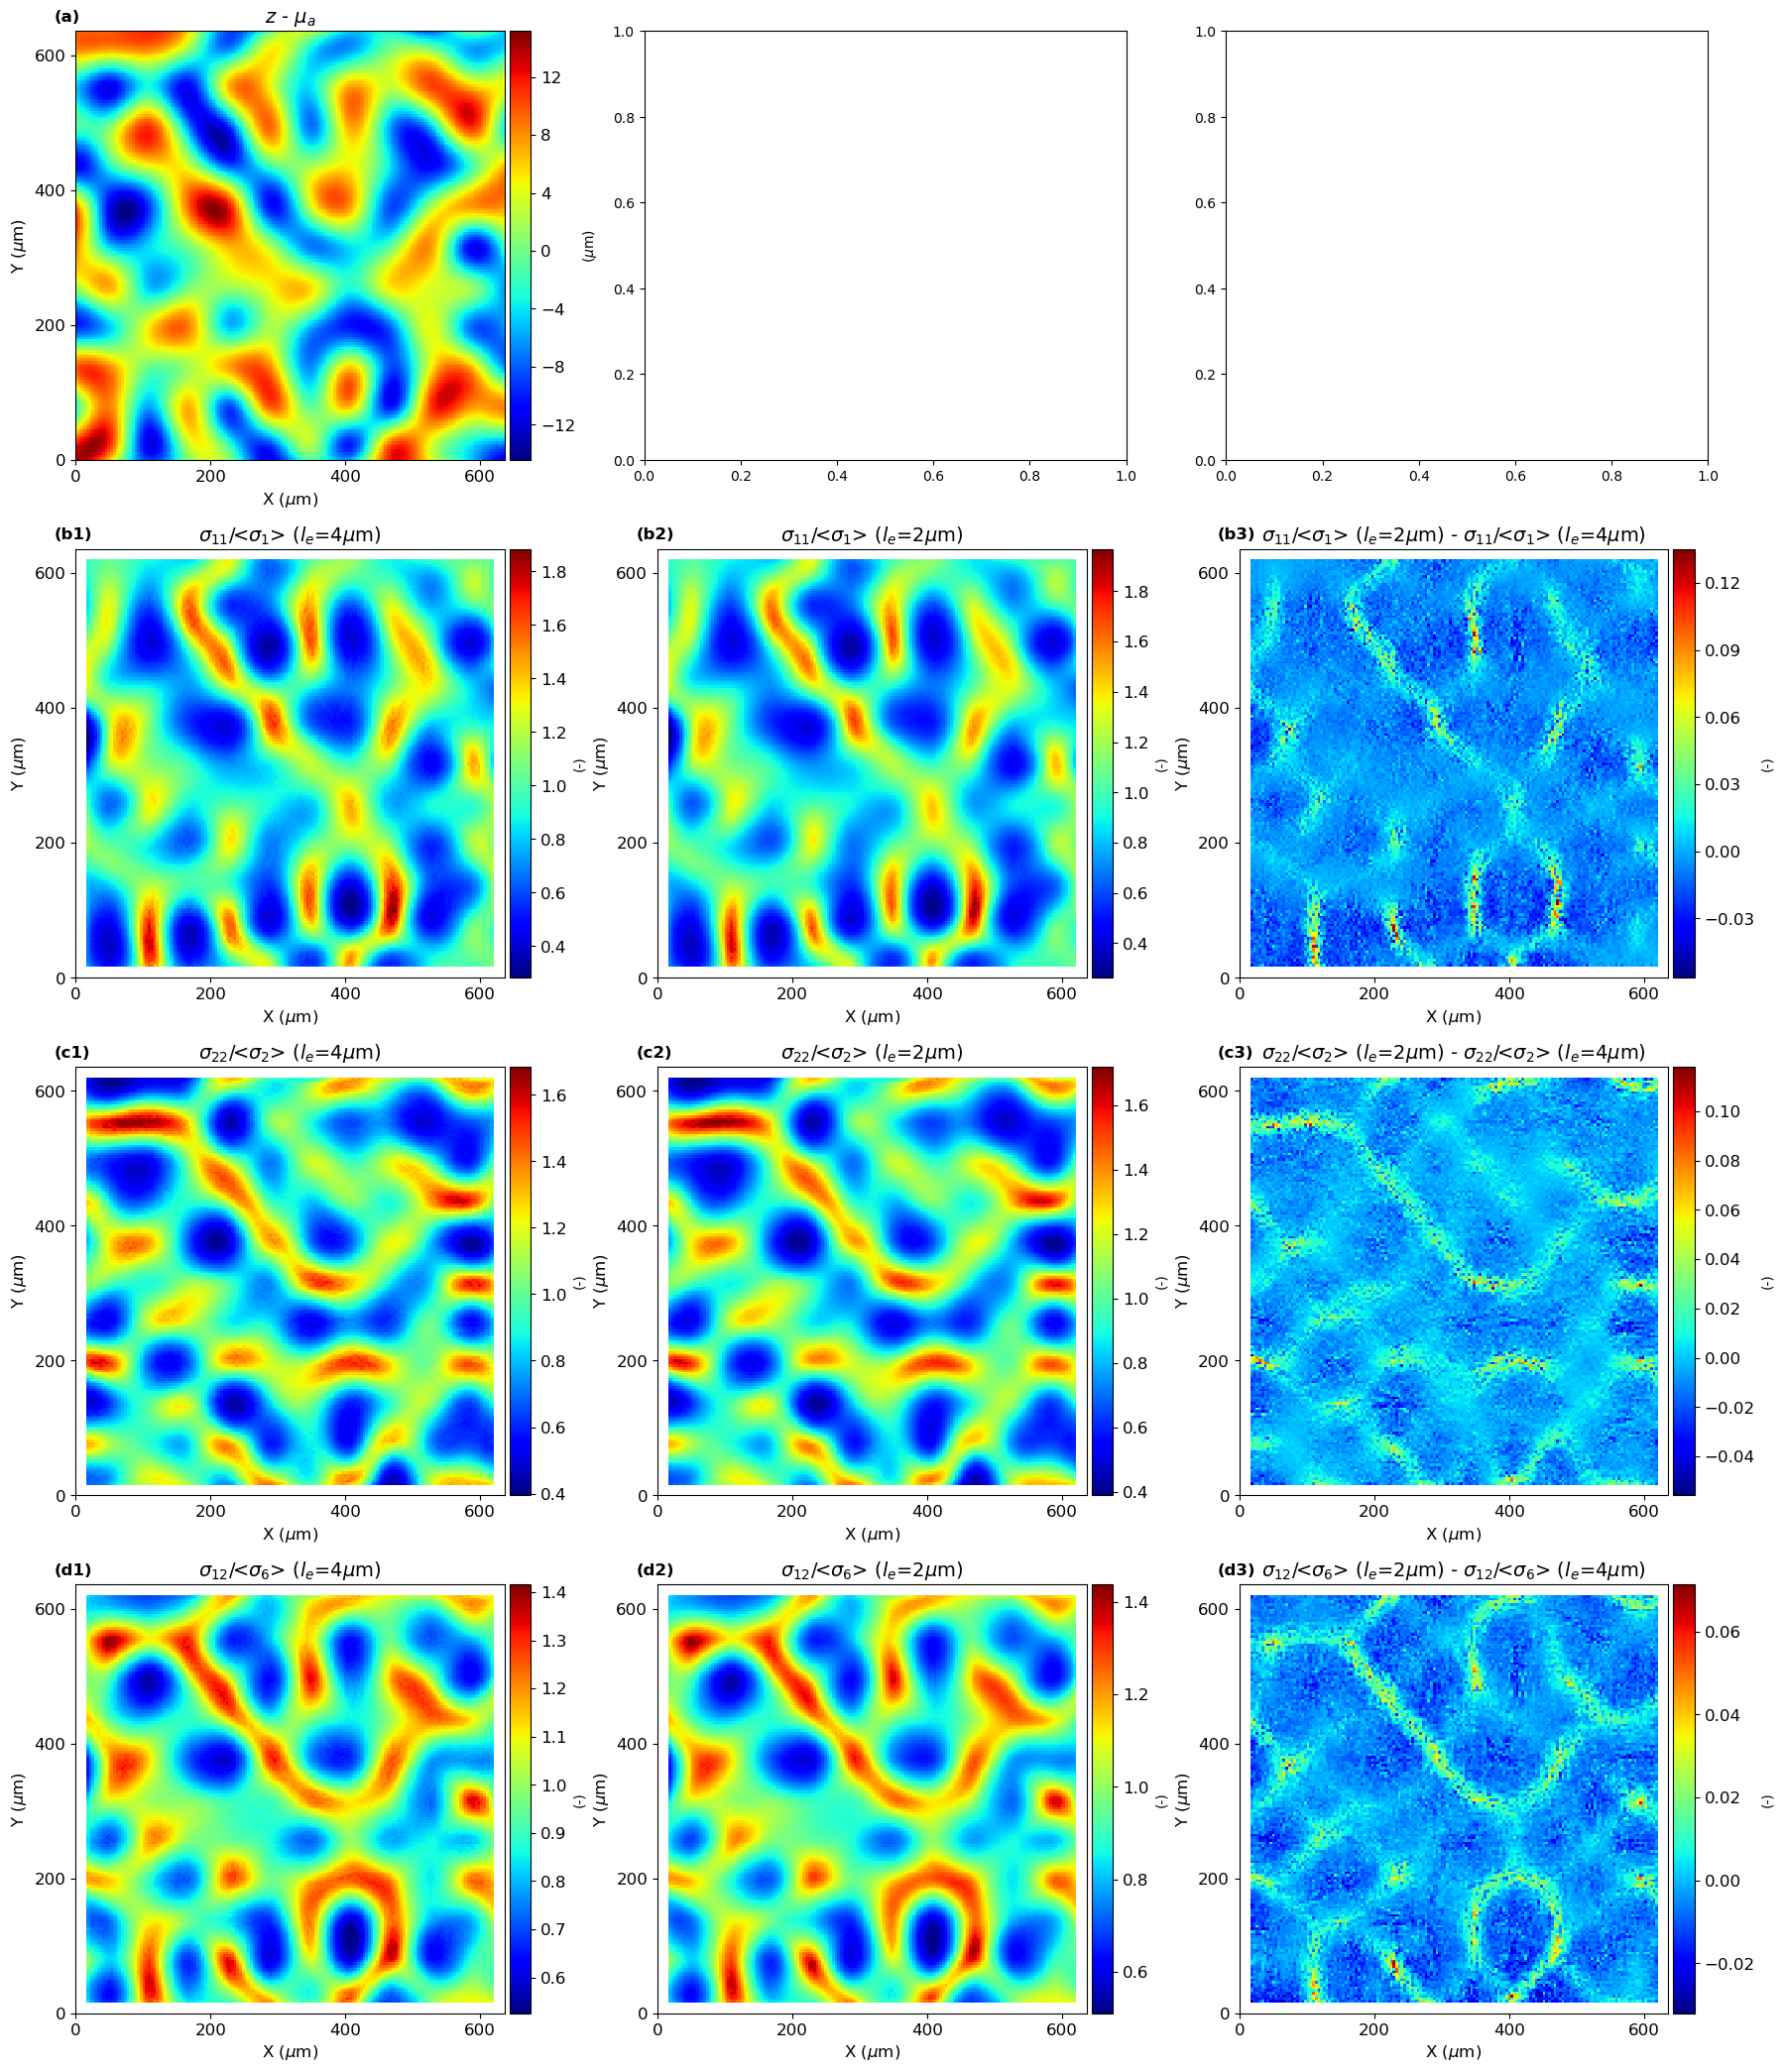

In [63]:
# Define the interval of structured grid which is denser than the control points
interval_struct_grids = 0.004   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 10000

half_crop_grids = 0
# effective_crop_length = 0.25
original_length_mm = 0.636
sum_field = 18  # Number of stress components to be extracted

# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed

# sparse mesh
sub_times = 1
file_struct_grids_sparse = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_sparse = extract_stress(structured_grid_xls_folder, file_struct_grids_sparse, sum_field)


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.csv"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = np.loadtxt(file_roughness_path, delimiter=',')
roughness_matrix = roughness_matrix * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$'
label = '($\mu$m)'
half_crop_grids = 0
corner_label = '(a)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)

# dense mesh
sub_times = 2
file_struct_grids_dense = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_dense = extract_stress(structured_grid_xls_folder, file_struct_grids_dense, sum_field)

# difference between the two meshes
norm_stress_diff = norm_stress_dense - norm_stress_sparse

# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

row_plot = 0
for i in range(len(steps_name)):
    for j in range(len(ss_comp)):

        if (i == 0 and j == 0) or (i == 1 and j == 1) or (i == 2 and j == 3):

            idx_stress = i*6 + j

            # pixels to be cropped off the border of the grid

            crop_pix = 4
            row_plot += 1
            row_label = row_labels[row_plot-1]

            if i == 0:     
                str_sig = "11"
                str_s = "1"          
            if i == 1:
                str_sig = "22"
                str_s = '2'    
            if i == 2:
                str_sig = "12"
                str_s = '6'    
            
            str_ele_4um = '$\mathit{l}$$_{e}$=4$\mu$m'
            str_ele_2um = '$\mathit{l}$$_{e}$=2$\mu$m'

            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_ele_4um})'
            # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
            half_crop_grids = 0
            corner_label = '(' + row_label + '1' +')'
            plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_sparse[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
            
            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_ele_2um})'
            half_crop_grids = 0
            corner_label = '(' + row_label + '2' +')'
            plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_dense[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
            
            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_ele_2um}) - $\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_ele_4um})'
            half_crop_grids = 0
            corner_label = '(' + row_label + '3' +')'
            plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_diff[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)


plt.tight_layout()
plt.show()


# Difference due to edge cropping

* Same geometry but with different length cropped from edges
* Saint-Venant effect is investigated

The interval of structured grid is 0.004 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C0_S1_ID10000.xlsx
[1] ->Now we are importing the grids with 0 grids cropped off the edge.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C13_S1_ID10000.xlsx
[2] ->Now we are importing the grids with 13 grids cropped off the edge.


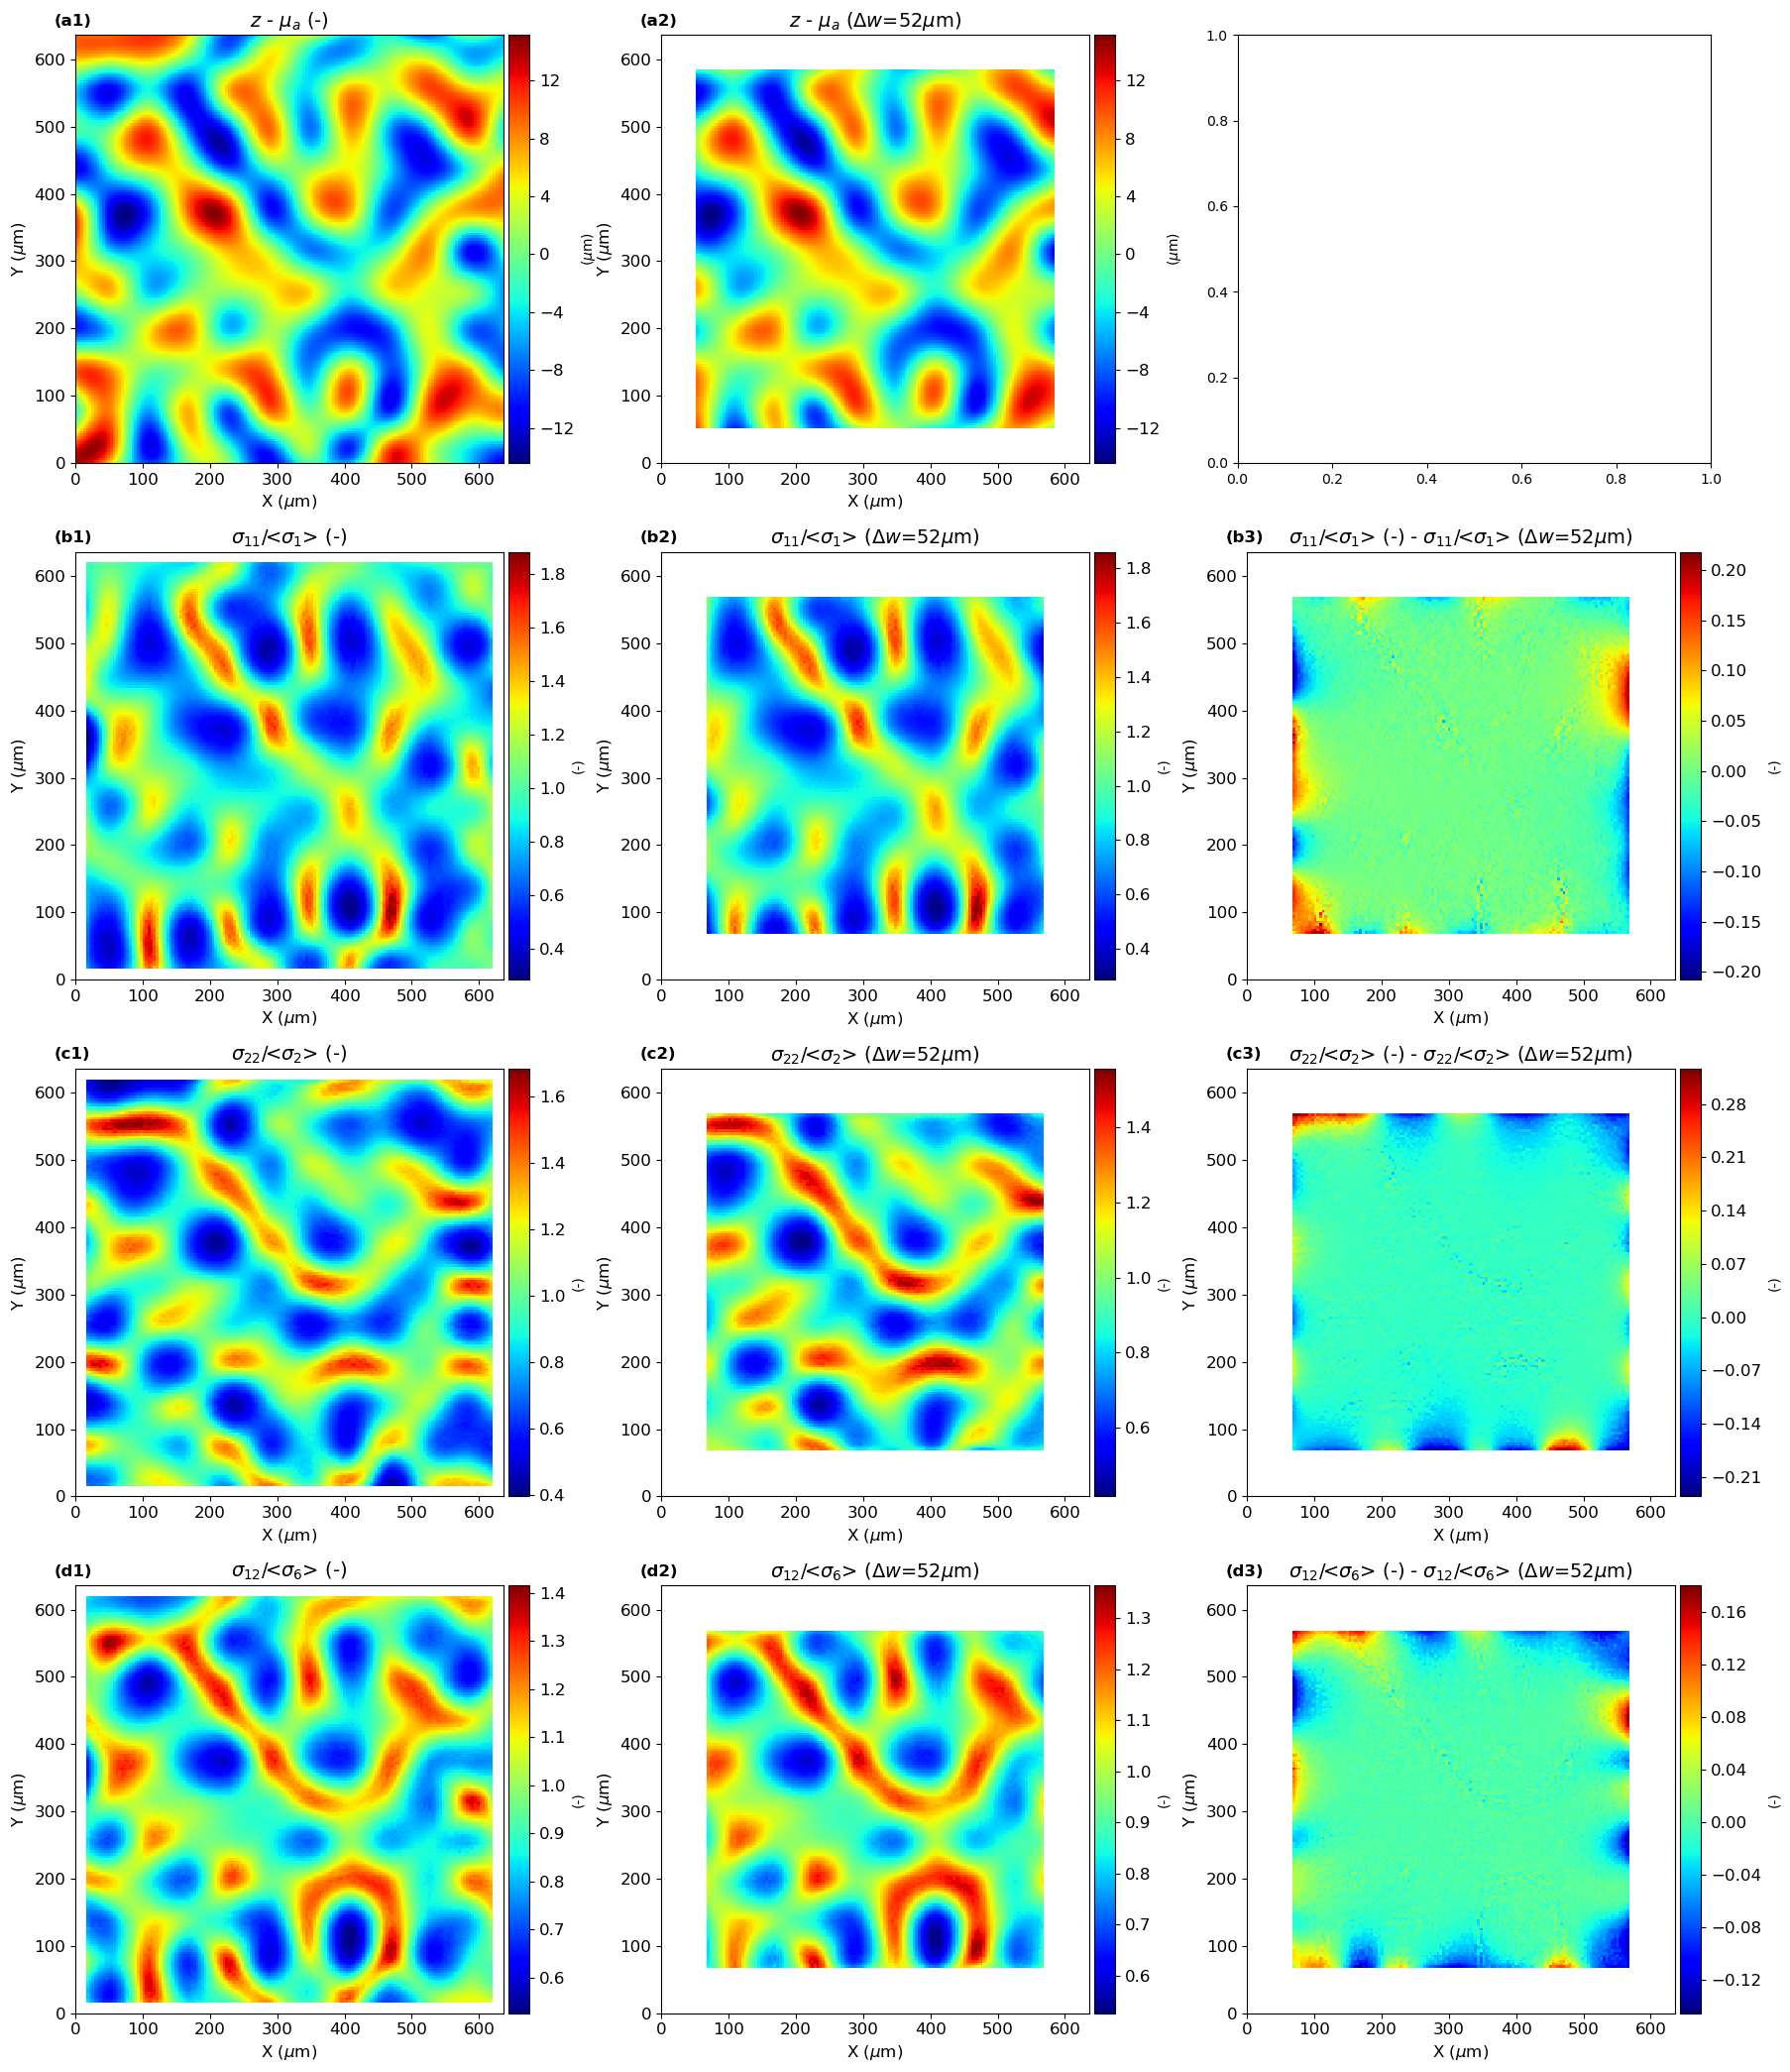

In [ ]:
# Define the interval of structured grid which is denser than the control points
interval_struct_grids = 0.004   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 10000

# effective_crop_length = 0.25
original_length_mm = 0.636
sub_times = 1
sum_field = 18  # Number of stress components to be extracted

# no cropping of the volume
half_crop_grids = 0
file_struct_grids_full = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_full = extract_stress(structured_grid_xls_folder, file_struct_grids_full, sum_field)
print(f"[1] ->Now we are importing the grids with {half_crop_grids} grids cropped off the edge.")

# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.csv"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = np.loadtxt(file_roughness_path, delimiter=',')
roughness_matrix = roughness_matrix * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ (-)'
label = '($\mu$m)'
corner_label = '(a1)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)


# with cropping of the volume
half_crop_grids = 13
file_struct_grids_crop = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_crop = extract_stress(structured_grid_xls_folder, file_struct_grids_crop, sum_field)

# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.csv"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = np.loadtxt(file_roughness_path, delimiter=',')
roughness_matrix = roughness_matrix * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ ($\Delta{w}$=52$\mu$m)'
label = '($\mu$m)'
corner_label = '(a2)'
plot_norm_field(fig, axes, 0, 1, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)

print(f"[2] ->Now we are importing the grids with {half_crop_grids} grids cropped off the edge.")
# difference between the two meshes with difference sizes in the first two dimensions
norm_stress_olap = norm_stress_full[half_crop_grids:-half_crop_grids,half_crop_grids:-half_crop_grids,:] - norm_stress_crop[:,:,:]

# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

row_plot = 0
for i in range(len(steps_name)):
    for j in range(len(ss_comp)):

        if (i == 0 and j == 0) or (i == 1 and j == 1) or (i == 2 and j == 3):

            idx_stress = i*6 + j

            # pixels to be cropped off the border of the grid

            crop_pix = 0
            row_plot += 1

            row_label = row_labels[row_plot-1]
            
            if i == 0:     
                str_sig = "11"
                str_s = "1"          
            if i == 1:
                str_sig = "22"
                str_s = '2'    
            if i == 2:
                str_sig = "12"
                str_s = '6'    
            
            str_full = '-'
            str_crop = '$\Delta{w}$=52$\mu$m'

            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_full})'
            # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
            half_crop_grids = 0
            crop_pix = 4
            corner_label = '(' + row_label + '1' +')'
            plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_full[:,:,idx_stress], crop_pix, half_crop_grids,original_length_mm, True)
            
            crop_pix = 4
            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_crop})'
            half_crop_grids = 13
            corner_label = '(' + row_label + '2' +')'
            plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_crop[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
            
            crop_pix = 4
            title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_full}) - $\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> ({str_crop})'
            half_crop_grids = 13
            corner_label = '(' + row_label + '3' +')'
            plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_olap[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)

plt.tight_layout()
plt.show()


# Prediction the trained CNN model in-ch=1

The trained CNN with 1 input channel is employed to predict the stress

The interval of structured grid is 0.004 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C0_S1_ID01000.xlsx
[1] ->Now we are importing the ground truth stress at grids in only tensile X step.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\pred_In1_norm_stress_struct_L636um_C0_S1_ID01000.xlsx
[2] ->Now we are importing the prediction at grids in only tensile-X step.


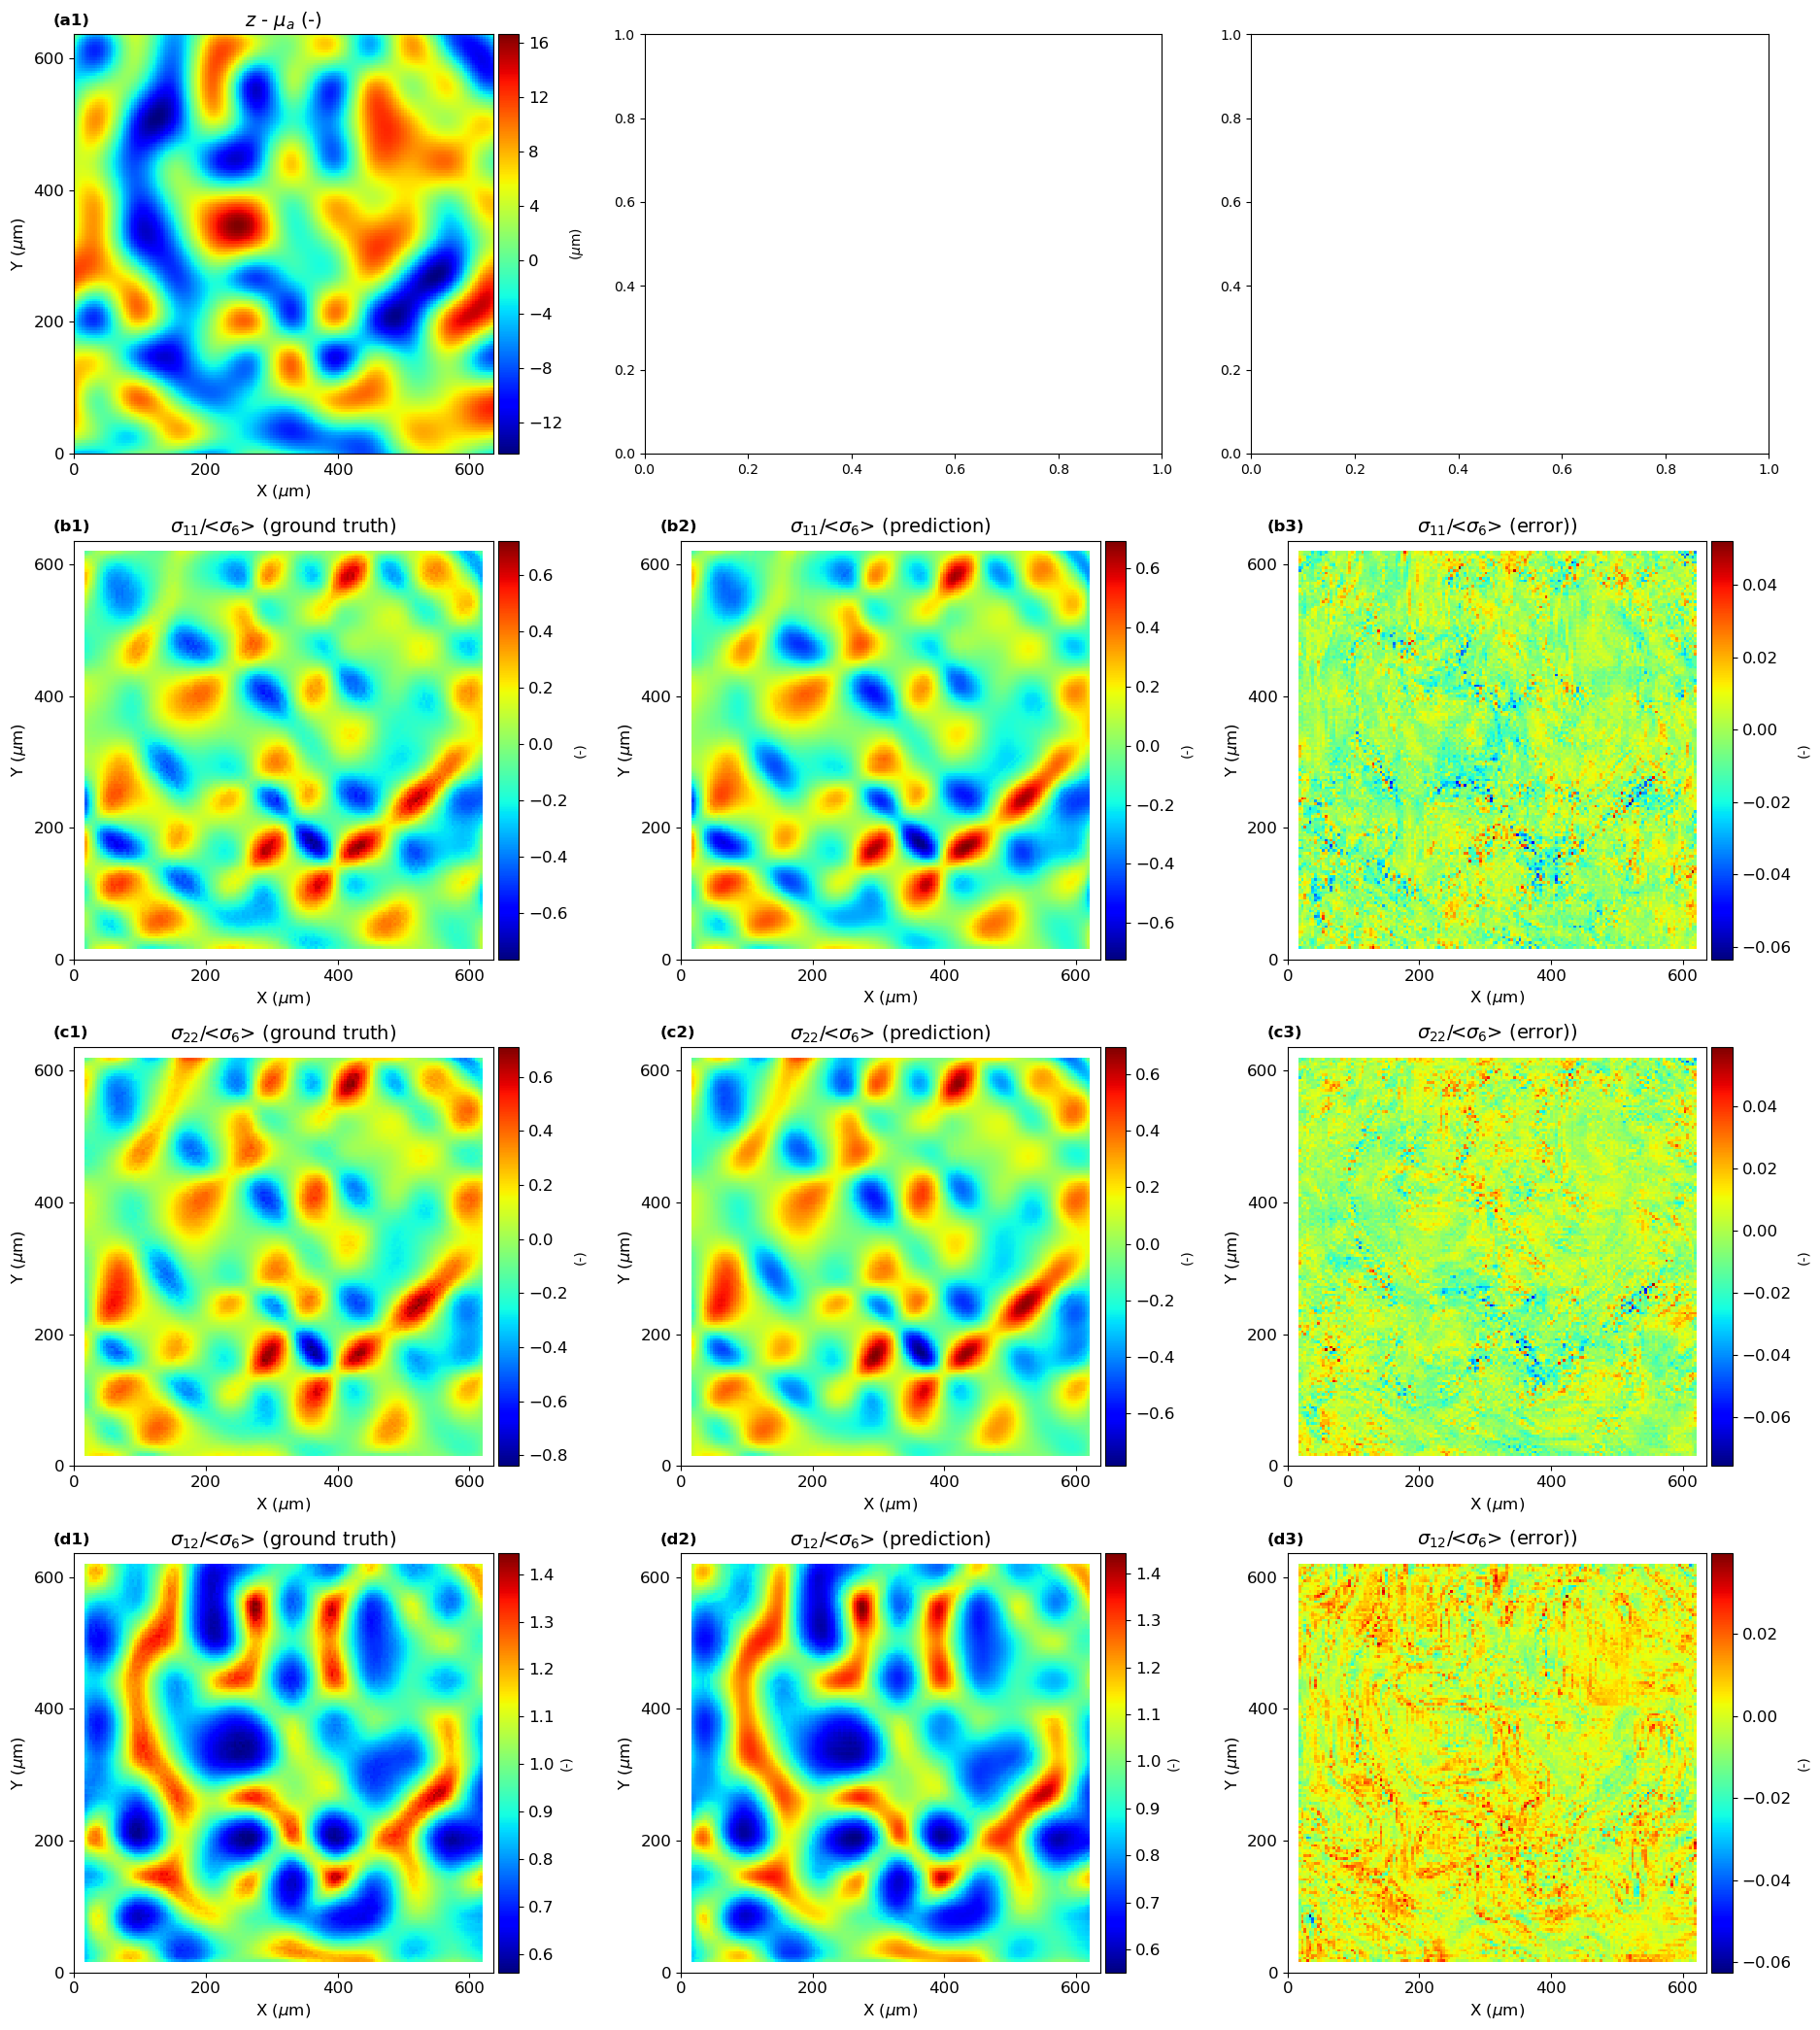

In [ ]:
"""
    Careful about the following variables
    >>>sum_field= 18    # Number of stress components to be extracted
    >>>idx_stress = j+12
"""
interval_struct_grids = 0.004   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 1000

# effective_crop_length = 0.25
original_length_mm = 0.636
sub_times = 1
half_crop_grids = 0
sum_field= 18    # Number of stress components to be extracted
in_channels = 1
# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(19, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.xlsx"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = pd.read_excel(file_roughness_path, sheet_name=0, header=None)
roughness_matrix = roughness_matrix.values.astype(float) * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ (-)'
label = '($\mu$m)'
corner_label = '(a1)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)


# grouth truth from finite element modeling
file_struct_grids_truth = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_truth = extract_stress(structured_grid_xls_folder, file_struct_grids_truth, sum_field)
print(f"[1] ->Now we are importing the ground truth stress at grids in only tensile X step.")


# prediction of CNN with in-channel=1
file_struct_grids_pred = f"pred_In{in_channels}_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_pred = extract_stress(structured_grid_xls_folder, file_struct_grids_pred, sum_field)
print(f"[2] ->Now we are importing the prediction at grids in only tensile-X step.")

# difference between the two meshes with difference sizes in the first two dimensions
norm_stress_diff = norm_stress_truth[:,:,:] - norm_stress_pred[:,:,:]

# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

str_s = '6'

row_plot = 0

for j in range(len(ss_comp)):

    if (j == 0) or (j == 1) or (j == 3):

        idx_stress = j+12

        # pixels to be cropped off the border of the grid

        crop_pix = 0
        row_plot += 1

        row_label = row_labels[row_plot-1]
        
        str_sig = ss_comp[j]

        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (ground truth)'
        # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        crop_pix = 4
        corner_label = '(' + row_label + '1' +')'
        plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_truth[:,:,idx_stress], crop_pix, half_crop_grids,original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (prediction)'
        corner_label = '(' + row_label + '2' +')'
        plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_pred[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (error))'
        corner_label = '(' + row_label + '3' +')'
        plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_diff[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)

plt.tight_layout()
plt.show()

# Prediction of larger input size

A 320 by 320 roughness profile was feed into the trained model

The interval of structured grid is 0.004 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L1276um_C0_S1_ID20000.xlsx
[1] ->Now we are importing the ground truth stress at grids in only tensile X step.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\pred_In1_norm_stress_struct_L1276um_C0_S1_ID20000.xlsx
[2] ->Now we are importing the prediction at grids in only tensile-X step.


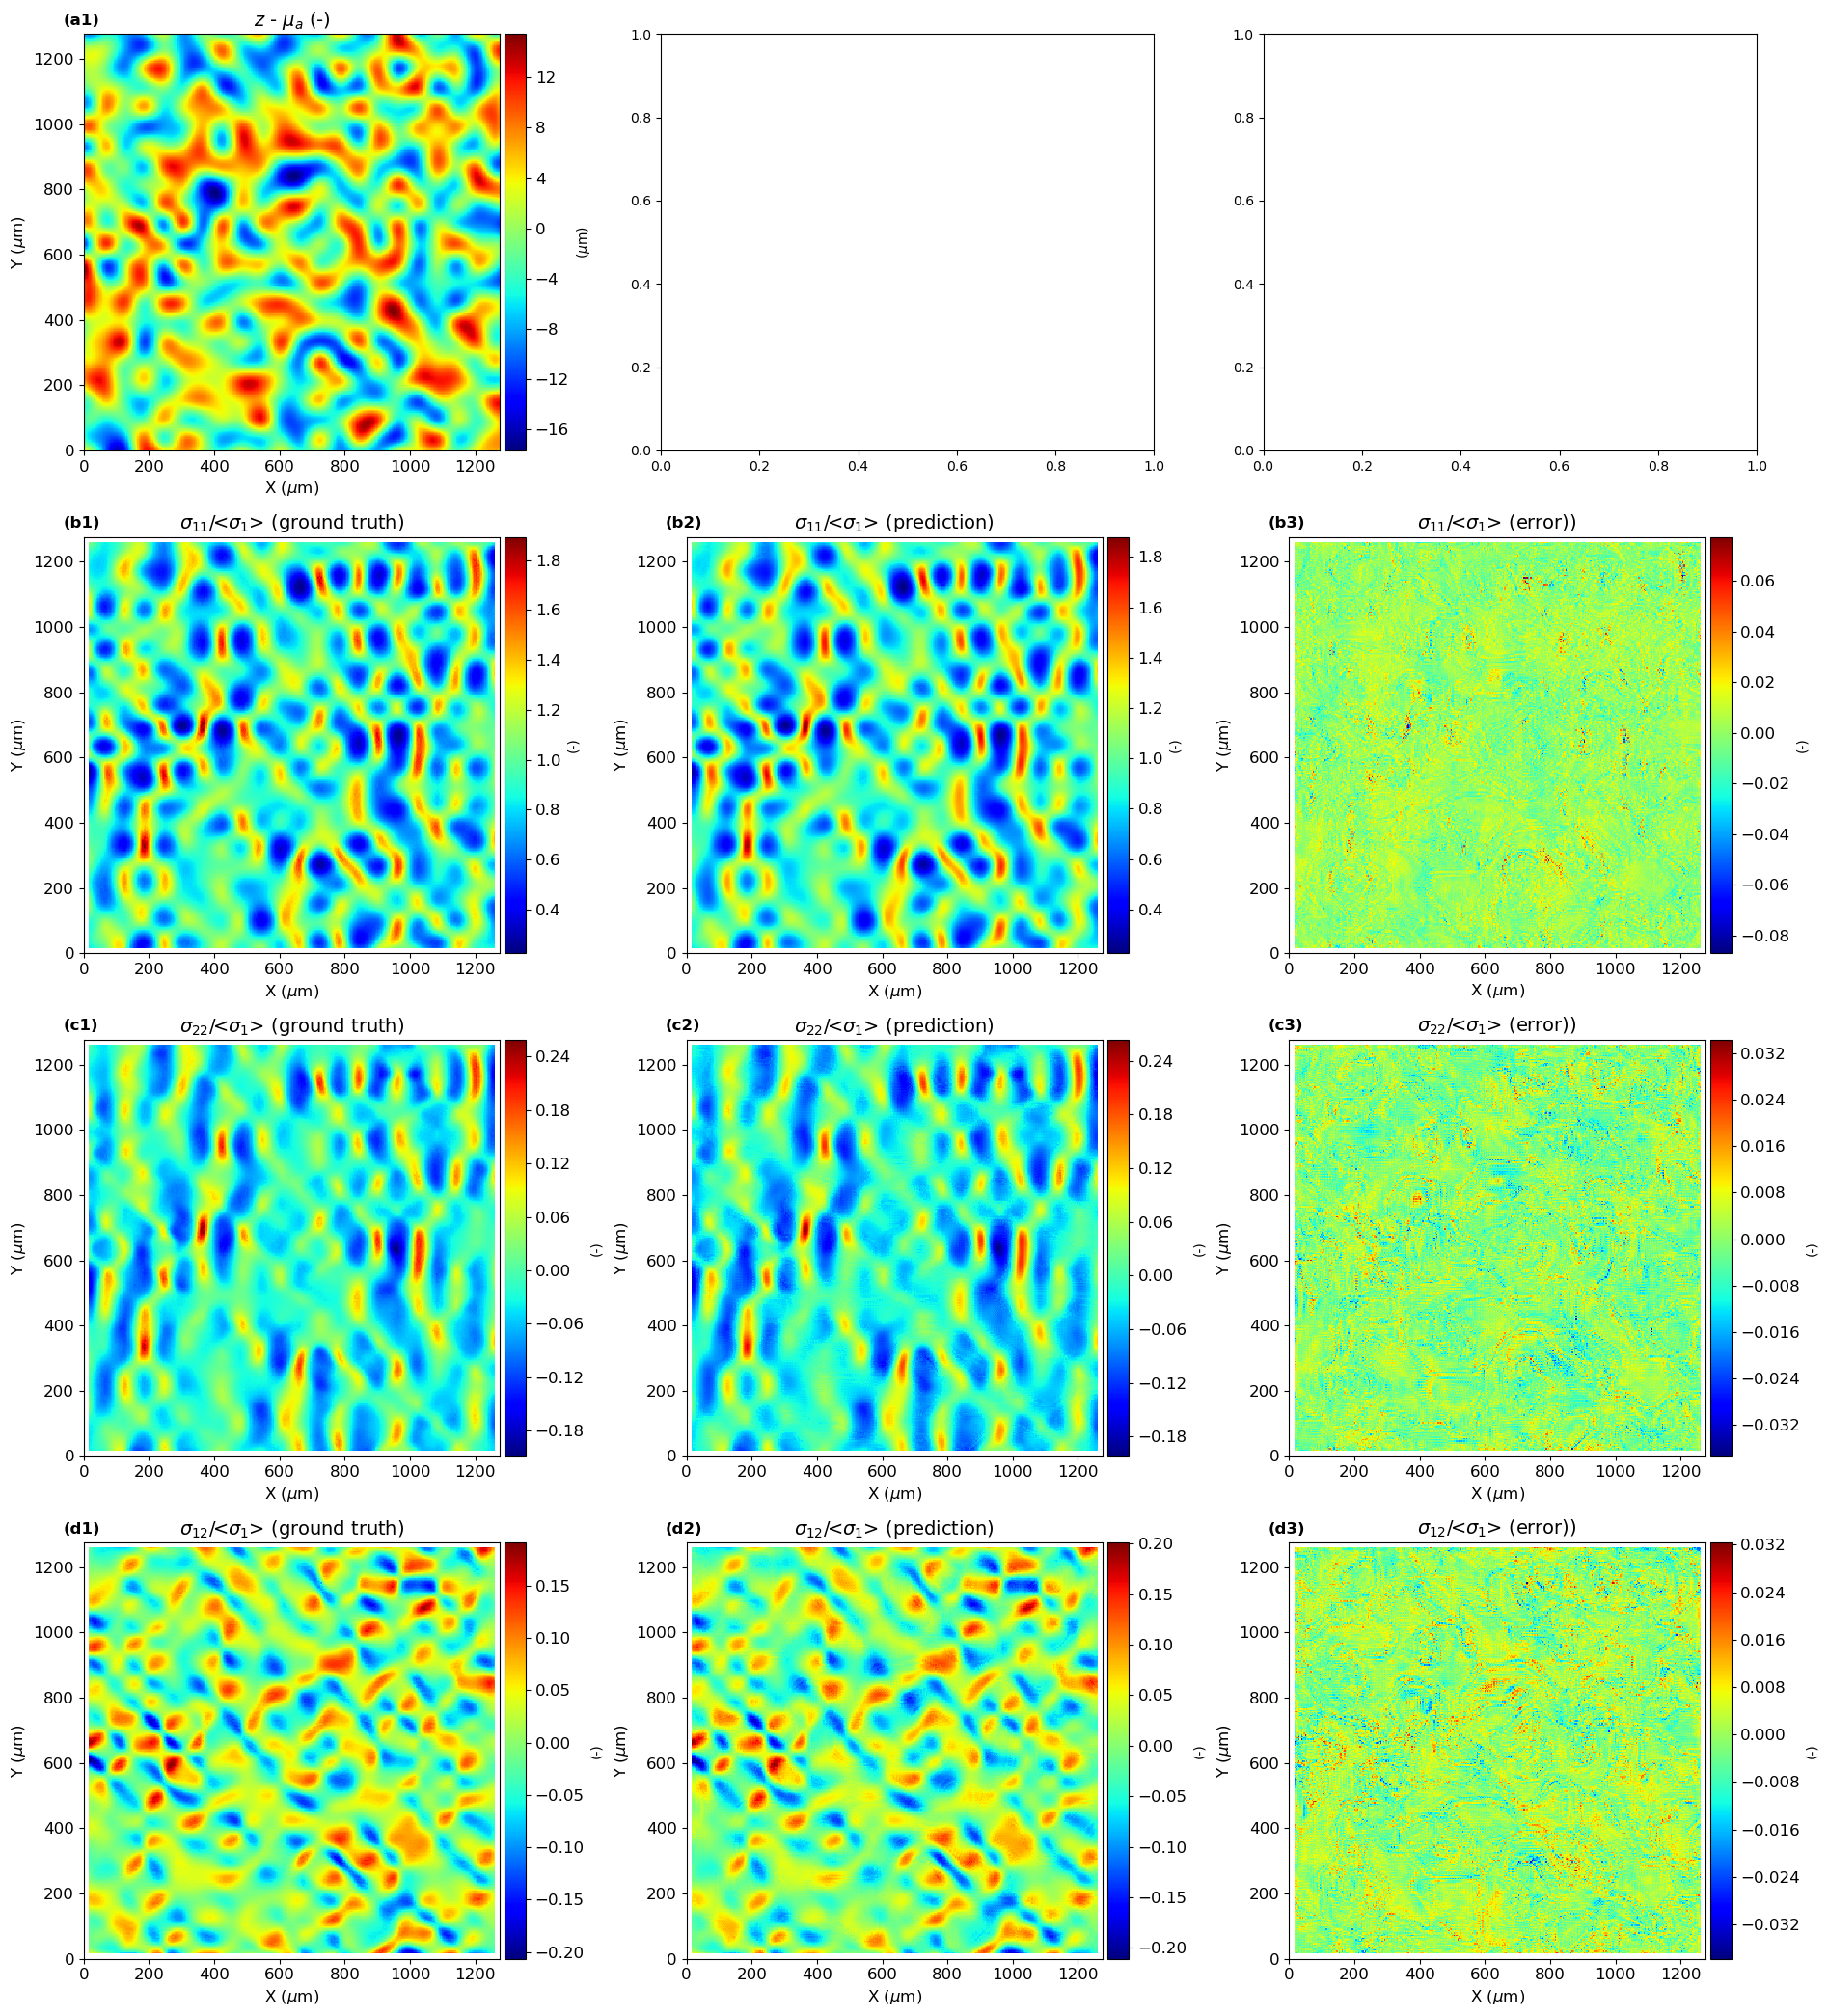

In [65]:
interval_struct_grids = 0.004   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 20000

# effective_crop_length = 0.25
original_length_mm = 1.276
sub_times = 1
half_crop_grids = 0
sum_field= 6    # Number of stress components to be extracted
in_channels = 1
# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(19, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.xlsx"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = pd.read_excel(file_roughness_path, sheet_name=0, header=None)
roughness_matrix = roughness_matrix.values.astype(float) * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ (-)'
label = '($\mu$m)'
corner_label = '(a1)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)


# grouth truth from finite element modeling
file_struct_grids_truth = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_truth = extract_stress(structured_grid_xls_folder, file_struct_grids_truth, sum_field)
print(f"[1] ->Now we are importing the ground truth stress at grids in only tensile X step.")


# prediction of CNN with in-channel=1
file_struct_grids_pred = f"pred_In{in_channels}_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_pred = extract_stress(structured_grid_xls_folder, file_struct_grids_pred, sum_field)
print(f"[2] ->Now we are importing the prediction at grids in only tensile-X step.")

# difference between the two meshes with difference sizes in the first two dimensions
norm_stress_diff = norm_stress_truth[:,:,:] - norm_stress_pred[:,:,:]

# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

str_s = '1'

row_plot = 0

for j in range(len(ss_comp)):

    if (j == 0) or (j == 1) or (j == 3):

        idx_stress = j

        # pixels to be cropped off the border of the grid

        crop_pix = 0
        row_plot += 1

        row_label = row_labels[row_plot-1]
        
        str_sig = ss_comp[j]

        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (ground truth)'
        # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        crop_pix = 4
        corner_label = '(' + row_label + '1' +')'
        plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_truth[:,:,idx_stress], crop_pix, half_crop_grids,original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (prediction)'
        corner_label = '(' + row_label + '2' +')'
        plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_pred[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (error))'
        corner_label = '(' + row_label + '3' +')'
        plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_diff[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)

plt.tight_layout()
plt.show()

# Resolution change using 1 or 3 in-channels

The interval of structured grid is 0.002 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L638um_C0_S2_ID10000.xlsx
[1] ->Now we are importing the ground truth stress at grids in only tensile X step.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\pred_In1_norm_stress_struct_L638um_C0_S2_ID10000.xlsx


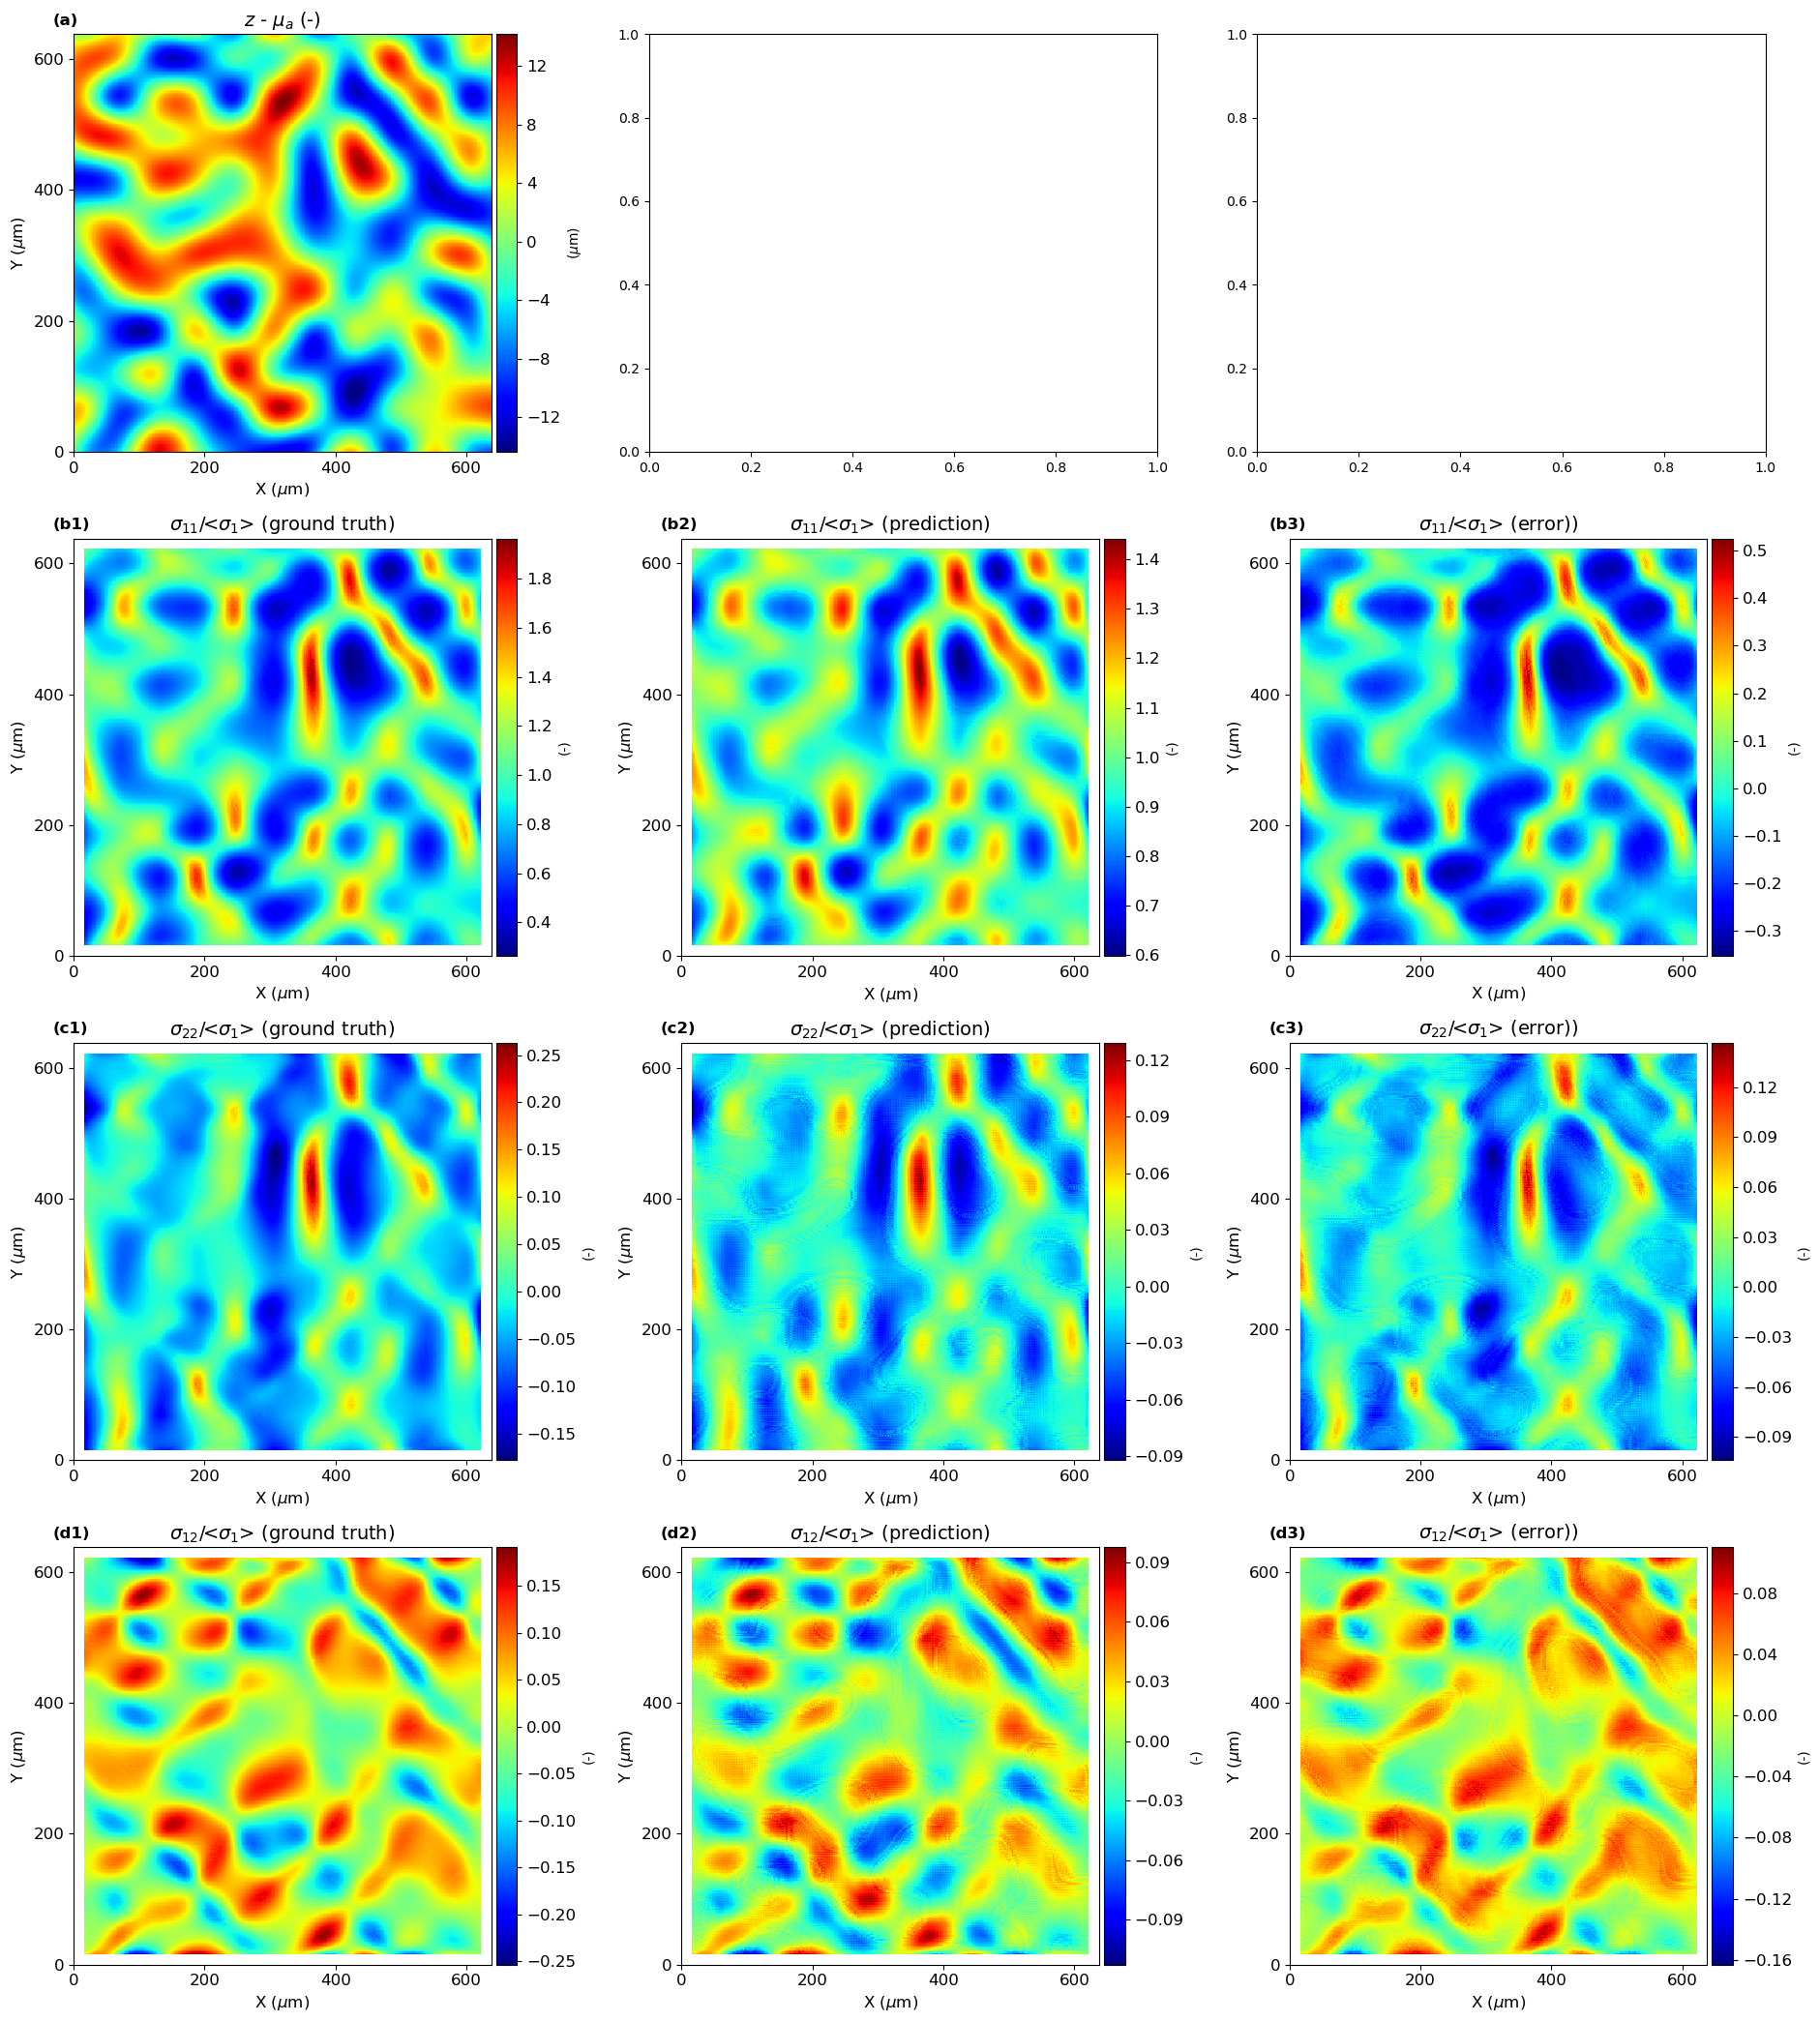

In [68]:
interval_struct_grids = 0.002   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 10000

# effective_crop_length = 0.25
original_length_mm = 0.638
sub_times = 2
half_crop_grids = 0

# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(19, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.xlsx"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = pd.read_excel(file_roughness_path, sheet_name=0, header=None)
roughness_matrix = roughness_matrix.values.astype(float) * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ (-)'
label = '($\mu$m)'
corner_label = '(a)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)


# grouth truth from finite element modeling
sum_field= 6    # Number of stress components to be extracted
crop_pix = 4
str_sig = '11'
str_s = '1'
str_in = 'in'
file_struct_grids_truth = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_truth = extract_stress(structured_grid_xls_folder, file_struct_grids_truth, sum_field)
print(f"[1] ->Now we are importing the ground truth stress at grids in only tensile X step.")



# prediction of CNN with in-channel=1
in_channels = 1
file_struct_grids_pred_1ch = f"pred_In{in_channels}_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_pred_1ch = extract_stress(structured_grid_xls_folder, file_struct_grids_pred_1ch, sum_field)
norm_stress_diff_1ch = norm_stress_truth[:,:,:] - norm_stress_pred_1ch[:,:,:]

# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

str_s = '1'

row_plot = 0

for j in range(len(ss_comp)):

    if (j == 0) or (j == 1) or (j == 3):

        idx_stress = j

        # pixels to be cropped off the border of the grid

        crop_pix = 0
        row_plot += 1

        row_label = row_labels[row_plot-1]
        
        str_sig = ss_comp[j]

        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (ground truth)'
        # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        crop_pix = 4
        corner_label = '(' + row_label + '1' +')'
        plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_truth[:,:,idx_stress], crop_pix, half_crop_grids,original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (prediction)'
        corner_label = '(' + row_label + '2' +')'
        plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_pred_1ch[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (error))'
        corner_label = '(' + row_label + '3' +')'
        plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_diff_1ch[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)

plt.tight_layout()
plt.show()


# Higher roughness Sa=10 um

The interval of structured grid is 0.004 mm.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\output_norm_stress_struct_L636um_C0_S1_ID30000.xlsx
[1] ->Now we are importing the ground truth stress at grids in only tensile X step.
✅ File exists: C:\Abaqus_Works\roughness_simulation\output_structured_grid\pred_In1_norm_stress_struct_L636um_C0_S1_ID30000.xlsx


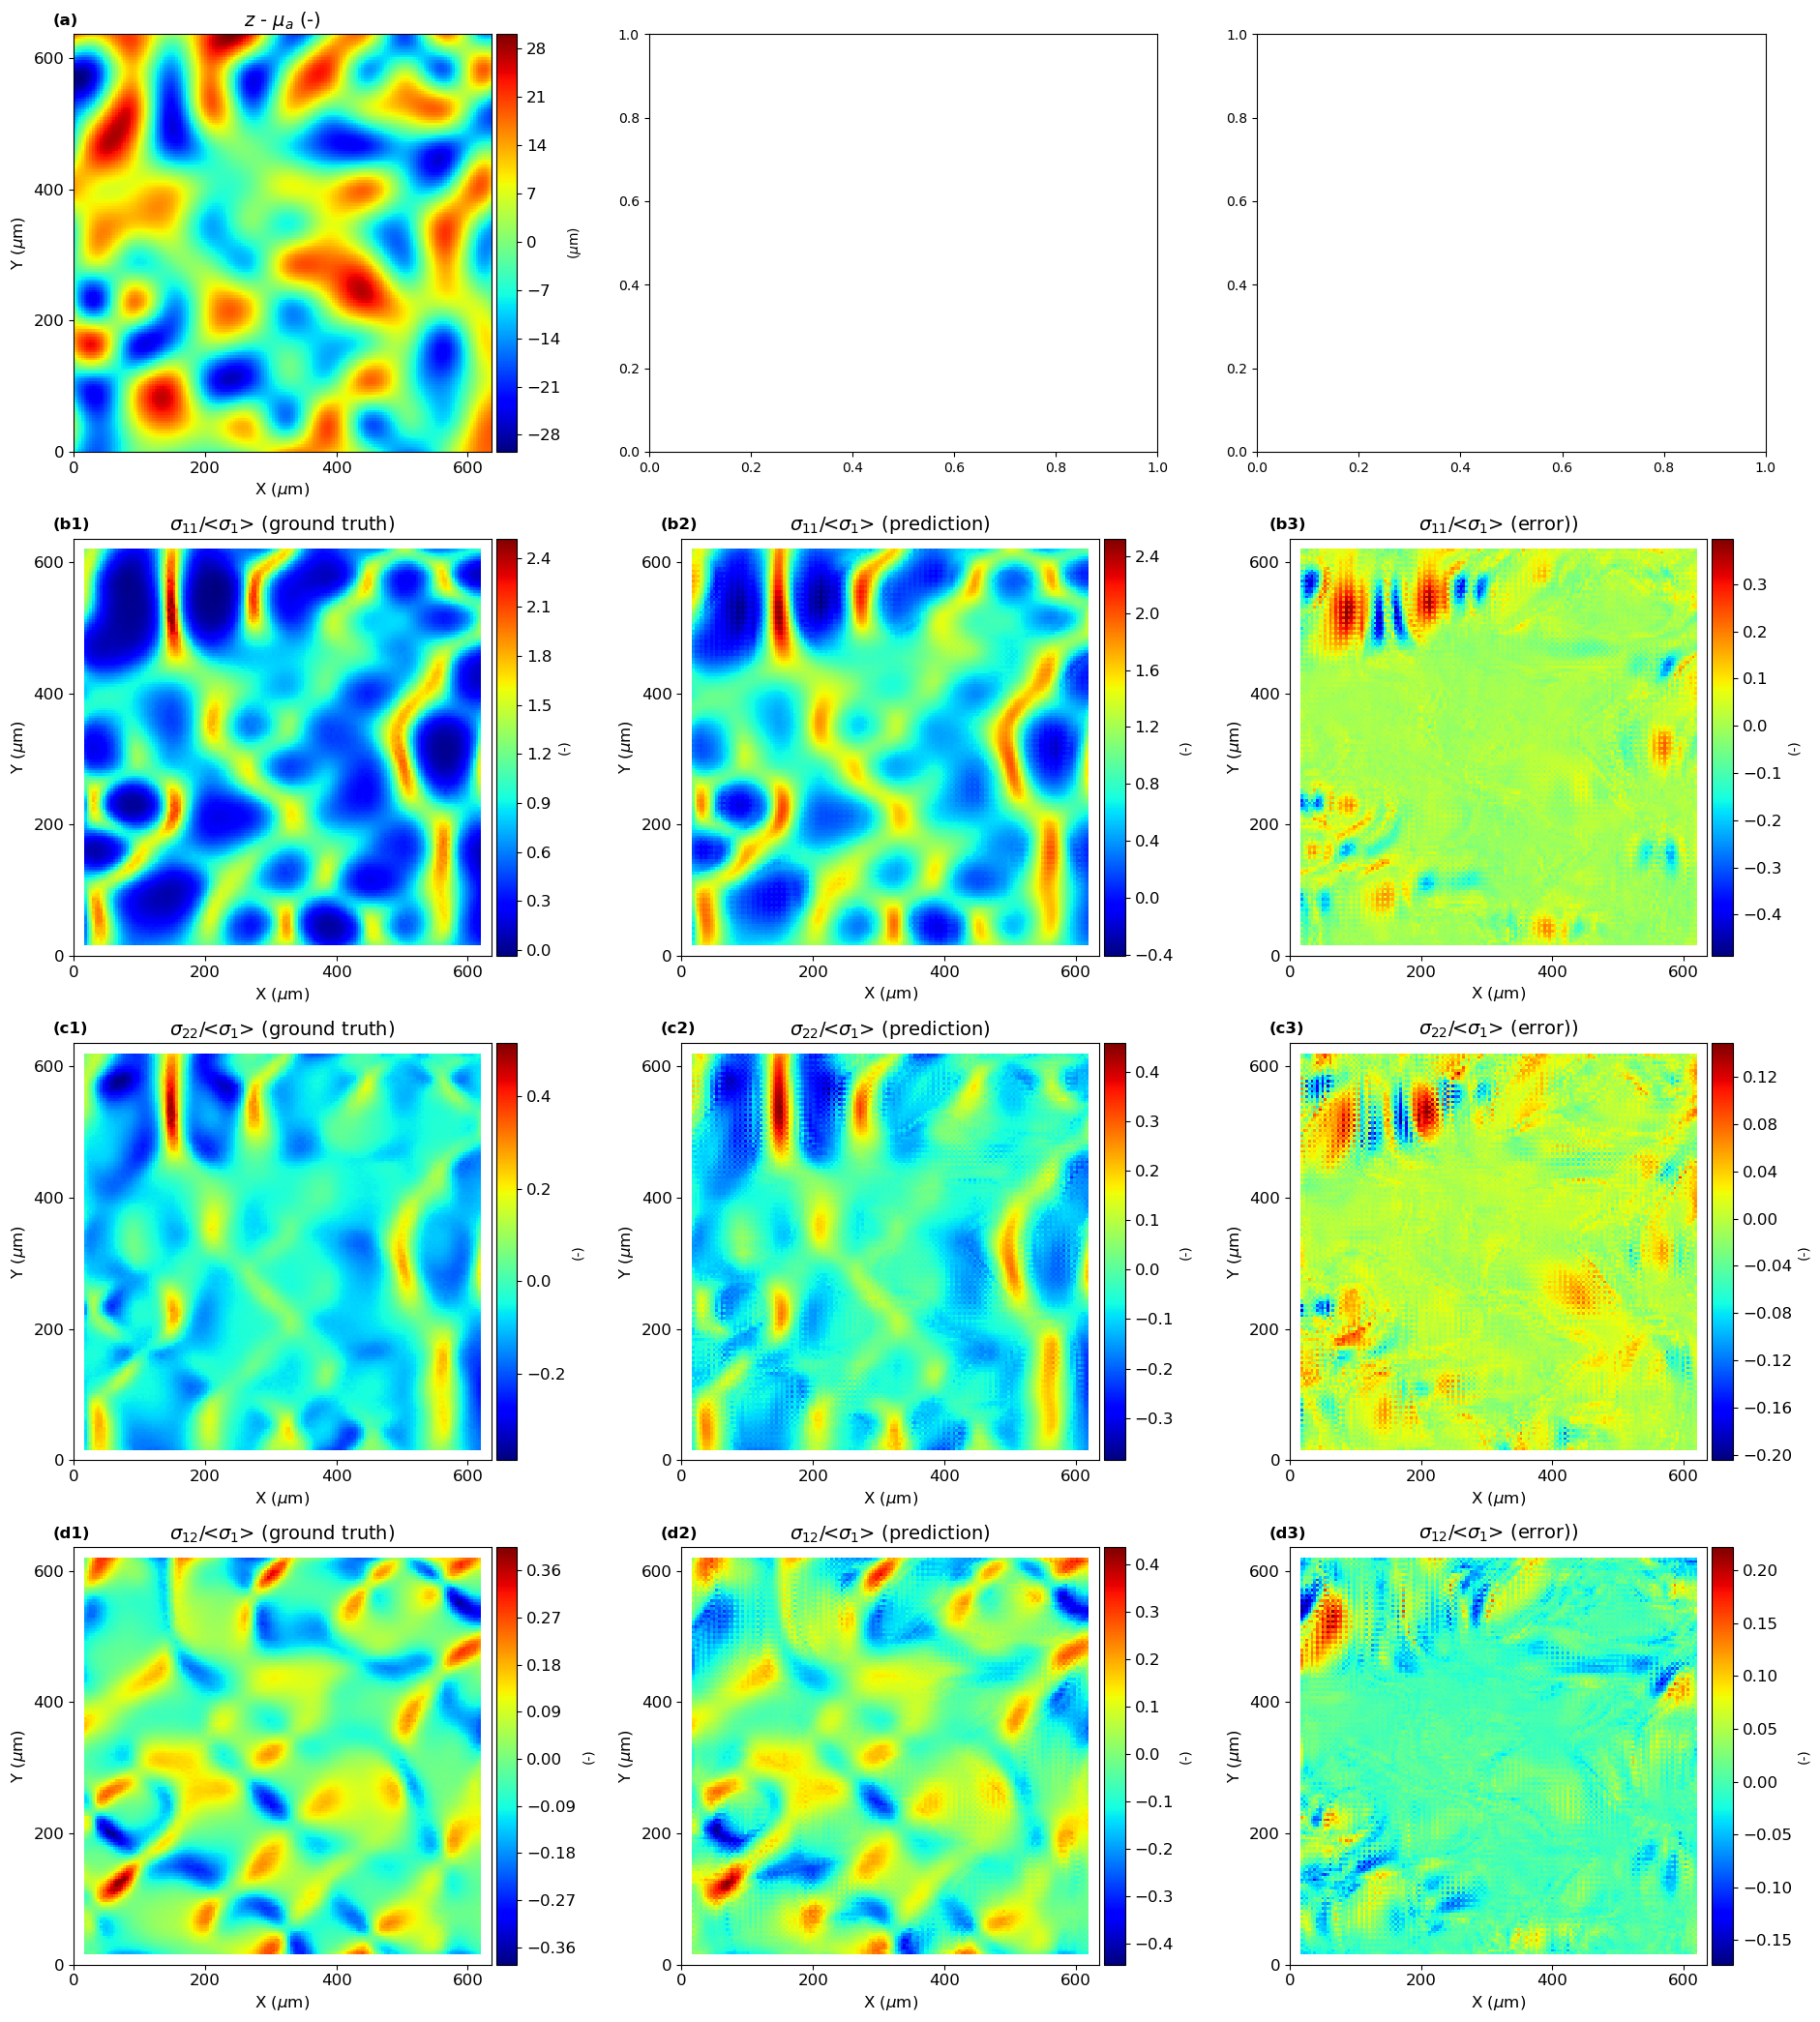

In [69]:
interval_struct_grids = 0.004   #   with unit of 'um'
print(f"The interval of structured grid is {interval_struct_grids} mm.")

id_job = 30000

# effective_crop_length = 0.25
original_length_mm = 0.636
sub_times = 1
half_crop_grids = 0

# Create figures and axes
fig, axes = plt.subplots(4, 3, figsize=(19, 21))  # Adjust figure size if needed
# fig, axes = plt.subplots(3, 3, figsize=(3, 108))  # Adjust figure size if needed


# the roughness data is saved in 'csv' files
file_roughness_sparse = f"input_surface_L{round(original_length_mm*1000)}um_C{half_crop_grids}_S{sub_times}_ID{id_job:0{5}}.xlsx"
file_roughness_path = os.path.join(input_rough_surf_csv_folder, file_roughness_sparse)
roughness_matrix = pd.read_excel(file_roughness_path, sheet_name=0, header=None)
roughness_matrix = roughness_matrix.values.astype(float) * 1000.0  # in the unit of micrometers

# draw the roughness 
crop_pix = 0

title = '$\mathit{z}$ - $\mu_{a}$ (-)'
label = '($\mu$m)'
corner_label = '(a)'
plot_norm_field(fig, axes, 0, 0, title, label, corner_label, roughness_matrix, crop_pix, half_crop_grids, original_length_mm, True)


# grouth truth from finite element modeling
sum_field= 6    # Number of stress components to be extracted
crop_pix = 4

file_struct_grids_truth = f"output_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_truth = extract_stress(structured_grid_xls_folder, file_struct_grids_truth, sum_field)
print(f"[1] ->Now we are importing the ground truth stress at grids in only tensile X step.")


# prediction of CNN with in-channel=1
in_channels = 1
file_struct_grids_pred_1ch = f"pred_In{in_channels}_norm_stress_struct_L{round(original_length_mm*1000)}um_C{int(half_crop_grids)}_S{int(sub_times)}_ID{id_job:0{5}}.xlsx"
norm_stress_pred_1ch = extract_stress(structured_grid_xls_folder, file_struct_grids_pred_1ch, sum_field)
norm_stress_diff_1ch = norm_stress_truth[:,:,:] - norm_stress_pred_1ch[:,:,:]


# step names and stress components
steps_name = ['TENSILE_X', 'TENSILE_Y', 'SHEAR']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

str_s = '1'

row_plot = 0

for j in range(len(ss_comp)):

    if (j == 0) or (j == 1) or (j == 3):

        idx_stress = j

        # pixels to be cropped off the border of the grid

        crop_pix = 0
        row_plot += 1

        row_label = row_labels[row_plot-1]
        
        str_sig = ss_comp[j]

        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (ground truth)'
        # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        crop_pix = 4
        corner_label = '(' + row_label + '1' +')'
        plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, norm_stress_truth[:,:,idx_stress], crop_pix, half_crop_grids,original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (prediction)'
        corner_label = '(' + row_label + '2' +')'
        plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, norm_stress_pred_1ch[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)
        
        crop_pix = 4
        title = f'$\\sigma_{{{str_sig}}}$/<$\\sigma_{{{str_s}}}$> (error))'
        corner_label = '(' + row_label + '3' +')'
        plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, norm_stress_diff_1ch[:,:,idx_stress], crop_pix, half_crop_grids, original_length_mm, True)

plt.tight_layout()
plt.show()


# Loss history under different U-Net setting

There are three hyperparameters in the CNN model
* Layers [4, 3]
* Sub-layers [3, 2]
* Skip connection: [Y, N]

In [3]:
def read_train_val_loss(file_folder, file_name):
    """
    Reads an Excel file with one sheet, no header, and returns the data as a NumPy array.
    
    Parameters:
    - file_path (str): The path to the Excel file.
    
    Returns:
    - data (numpy.ndarray): A NumPy array containing the data from the Excel file.
    """

    try:
        file_path = os.path.join(file_folder, file_name)
        # Read the Excel file (no header, one sheet)
        df = pd.read_excel(file_path, header=None)  # header=None indicates no header row
        
        # Ensure the data has the expected shape (50 rows, 2 columns)
        if df.shape != (50, 2):
            raise ValueError(f"Unexpected data shape: {df.shape}. Expected (50, 2).")
        
        # Convert the DataFrame to a NumPy array
        data = df.to_numpy()
        return data
    
    except Exception as e:
        print(f"Error reading the Excel file: {e}")
        return None

Read losses from the combination of LAYER [4, 3], SubLayer [3, 2] and Skip connection [True, False]

In [4]:
cnn_model_folder = 'C:\\Abaqus_Works\\roughness_simulation'

loss_matrices = []
#-------------------Layer [4]-Sub Layer [3]----------
num_layer = 4
num_sublayer = 3
in_channels = 1
name_step = 'TENSILE_X'

file_cnn_model = f"net_{name_step}_L{num_layer}_SubL{num_sublayer}_In{in_channels}_PReLU.xlsx"

loss_L4_S3_I1 = read_train_val_loss(cnn_model_folder, file_cnn_model)
loss_matrices.append(loss_L4_S3_I1)

#-------------------Layer [4]-Sub Layer [2]-----------
num_layer = 4
num_sublayer = 2
in_channels = 1
name_step = 'TENSILE_X'

file_cnn_model = f"net_{name_step}_L{num_layer}_SubL{num_sublayer}_In{in_channels}_PReLU.xlsx"

loss_L4_S3_I1 = read_train_val_loss(cnn_model_folder, file_cnn_model)
loss_matrices.append(loss_L4_S3_I1)

#-------------------Layer [3]-Sub Layer [2]----------
num_layer = 3
num_sublayer = 2
in_channels = 1
name_step = 'TENSILE_X'

file_cnn_model = f"net_{name_step}_L{num_layer}_SubL{num_sublayer}_In{in_channels}_PReLU.xlsx"

loss_L3_S2_I1 = read_train_val_loss(cnn_model_folder, file_cnn_model)
loss_matrices.append(loss_L3_S2_I1)

Plot the losses change through epochs in all six cases

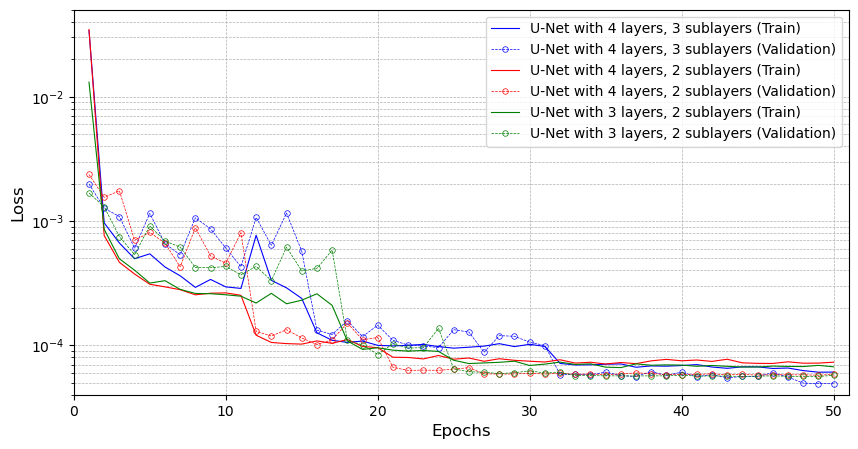

In [6]:

# Labels for the 6 combinations
labels = [
    r"U-Net with 4 layers, 3 sublayers",
    r"U-Net with 4 layers, 2 sublayers",
    r"U-Net with 3 layers, 2 sublayers"
]

# Colors for the 6 combinations
# colors = ['blue', 'green', 'red', 'orange', 'black', 'cyan']
colors = ['blue', 'red', 'green']

plt.figure(figsize=(10, 5))  # Set figure size *Global*
# plt.figure(figsize=(5, 3))  # Set figure size  *Local*

# Loop through each matrix and plot training losses
for i, matrix in enumerate(loss_matrices):
    epochs = np.arange(1, matrix.shape[0] + 1)  # Epochs (1 to 50)
    train_loss = matrix[:, 0]  # First column: training loss
    valid_loss = matrix[:, 1]  # Second column: validation loss
    idx = int(i/2)
    # if i % 2 == 0:        
    # Plot training loss (solid line)
    plt.plot(epochs, train_loss, label=labels[i] + " (Train)", color=colors[i], linestyle='-', linewidth=0.8)
    
    # Plot validation loss (dashed line)
    # plt.plot(epochs, valid_loss, label=labels[i] + " (Validation)", color=colors[idx], linestyle='--', linewidth=0.8)
# else:
    # Plot training loss (solid line)
    # plt.plot(epochs, train_loss, label=labels[i] + " (Train)", color=colors[idx], linestyle='-', linewidth=0.5, 
    #          marker='o', markerfacecolor='none', markeredgecolor=colors[idx], markeredgewidth=0.5, markersize=8)
    
    # Plot validation loss (dashed line)
    plt.plot(epochs, valid_loss, label=labels[i] + " (Validation)", color=colors[i], linestyle='--', linewidth=0.5, 
                marker='o', markerfacecolor='none', markeredgecolor=colors[i], markeredgewidth=0.5, markersize=4)

# Set logarithmic scale for the vertical axis
plt.yscale('log')

# Add labels, legend, and title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
# plt.title("Training and Validation Losses", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(fontsize=10, loc='upper right')

# for global view
plt.xlim(0, 51)
plt.ylim(4E-5,5E-2)
# for local view
# plt.xlim(39, 51)
# plt.ylim(4E-5,8E-5)


# Show the plot
plt.show()